In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def is_valid_image(path):
    try:
        # Try to open the image file
        Image.open(path)
        return True
    except (IOError, FileNotFoundError):
        return False


In [3]:
from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)

    def __getitem__(self, index):
        path, target = self.samples[index]
        while not is_valid_image(path):
            index = (index + 1) % len(self.samples)
            path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [4]:
class CondensationAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(CondensationAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


In [5]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout2 = nn.Dropout(0.25)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.ca = CondensationAttention(512)  # Add Condensation Attention Layer

        self.fc = nn.Linear(512 * 14 * 14, 10)  # Corrected dimensions

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        x = self.ca(x)  # Apply Condensation Attention

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [6]:
dataset_path = '/kaggle/input/diamos-cyclegan/leaves'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CustomImageFolder(root=dataset_path, transform=transform)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model, criterion, optimizer, and scheduler
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)


In [7]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=3):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
        
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_accuracy = correct_val / total_val
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        
        print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}')
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies


Epoch 1/3, Loss: 2.5851, Accuracy: 0.7077
Validation Loss: 0.5236, Validation Accuracy: 0.8189
Epoch 2/3, Loss: 0.4198, Accuracy: 0.8439
Validation Loss: 0.3574, Validation Accuracy: 0.8547
Epoch 3/3, Loss: 0.2939, Accuracy: 0.8776
Validation Loss: 0.3355, Validation Accuracy: 0.8612


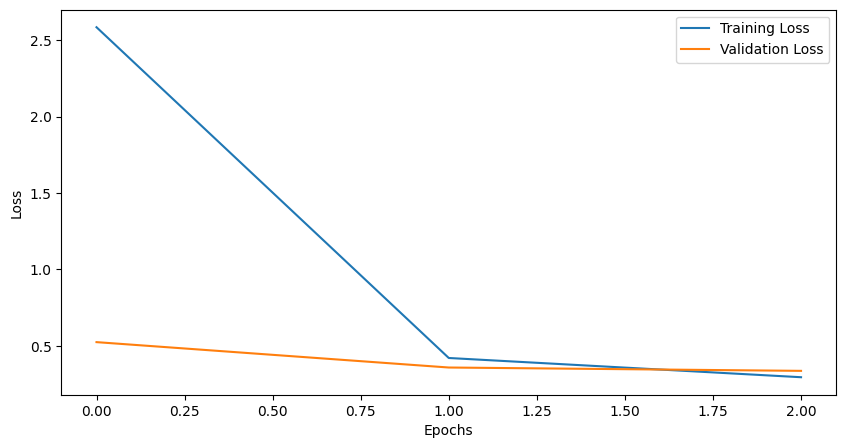

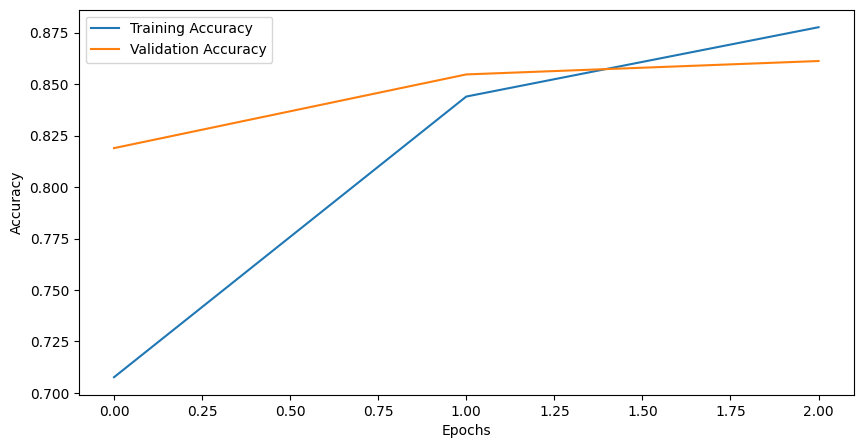

In [8]:
trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=3)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [9]:
# New Code: Grad-CAM Visualization
from torchvision import models
import torch
import torch.nn.functional as F
from torch.autograd import Function
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hook to capture gradients
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.conv_output = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        # Register hooks
        target_layer = dict([*self.model.named_modules()])[self.target_layer]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        model_output = self.model(input_image)

        if target_class is None:
            target_class = np.argmax(model_output.cpu().data.numpy())
        
        # Zero grads
        self.model.zero_grad()

        # Target for backprop
        target = model_output[0][target_class]
        target.backward()

        # Get the gradients
        guided_gradients = self.gradients.cpu().data.numpy()[0]
        target = self.conv_output.cpu().data.numpy()[0]

        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))

        # Compute Grad-CAM
        cam = np.zeros(target.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_image.shape[2:])
        cam -= np.min(cam)
        cam /= np.max(cam)
        return cam
    
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [11]:
# Paths to your images (replace these with the actual paths)
image_paths = [
    '/kaggle/input/diamos-cyclegan/leaves/curl/1.jpg',
    '/kaggle/input/diamos-cyclegan/leaves/healthy/113.jpg',
    '/kaggle/input/diamos-cyclegan/leaves/slug/u1007.jpg',
    '/kaggle/input/diamos-cyclegan/leaves/spot/u1227.jpg'
]


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


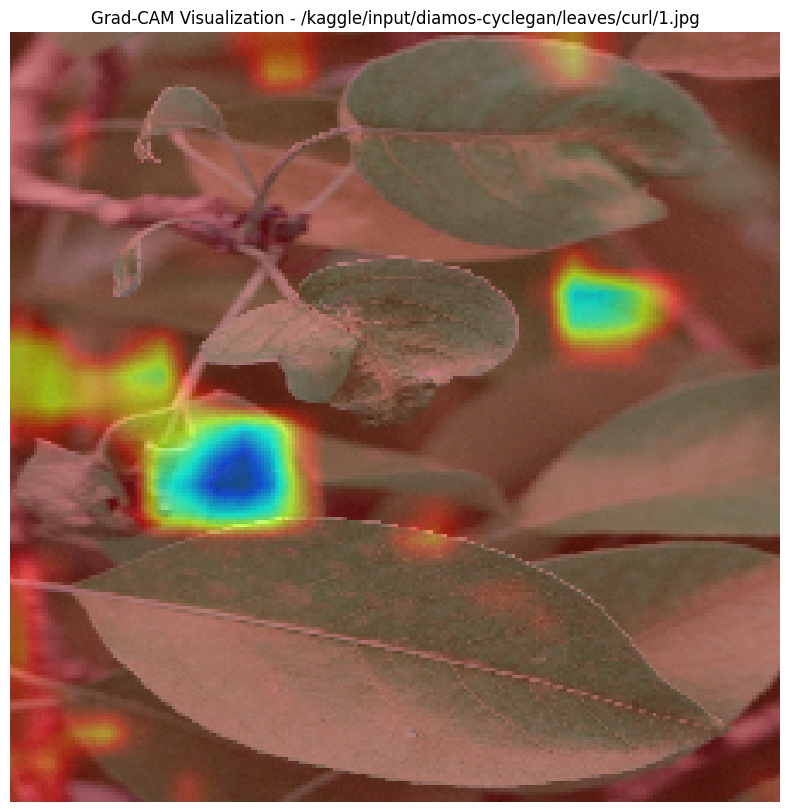

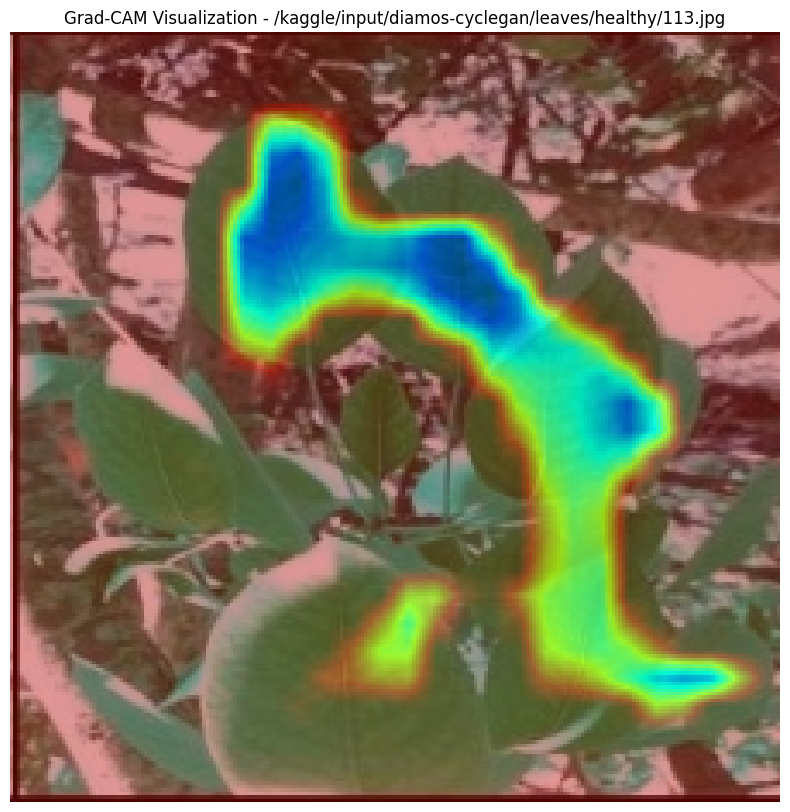

/tmp/ipykernel_24/2716828001.py:50: RuntimeWarning: invalid value encountered in divide
  cam /= np.max(cam)
/tmp/ipykernel_24/2716828001.py:54: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)


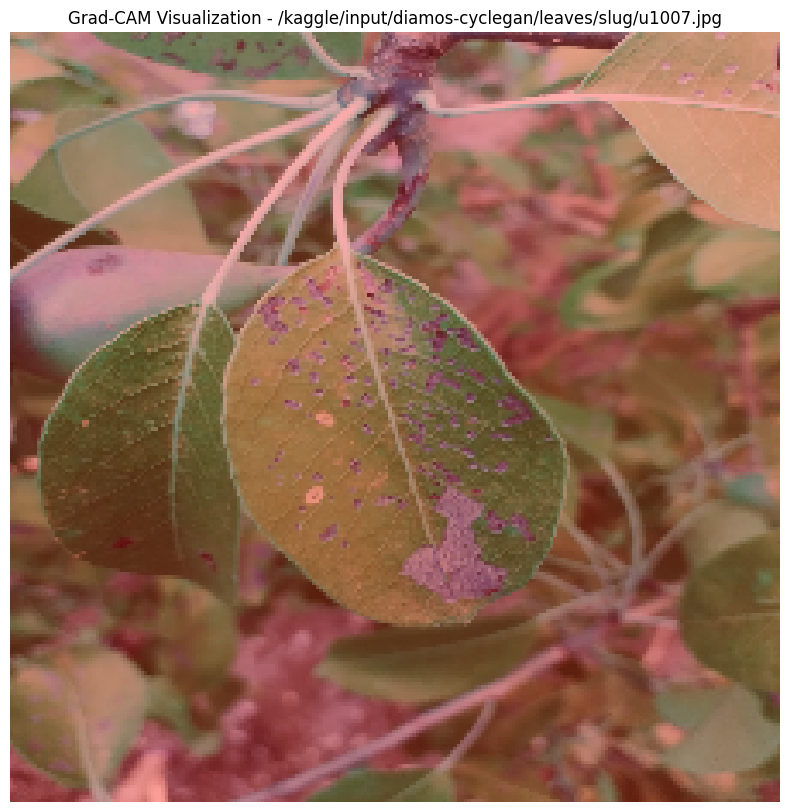

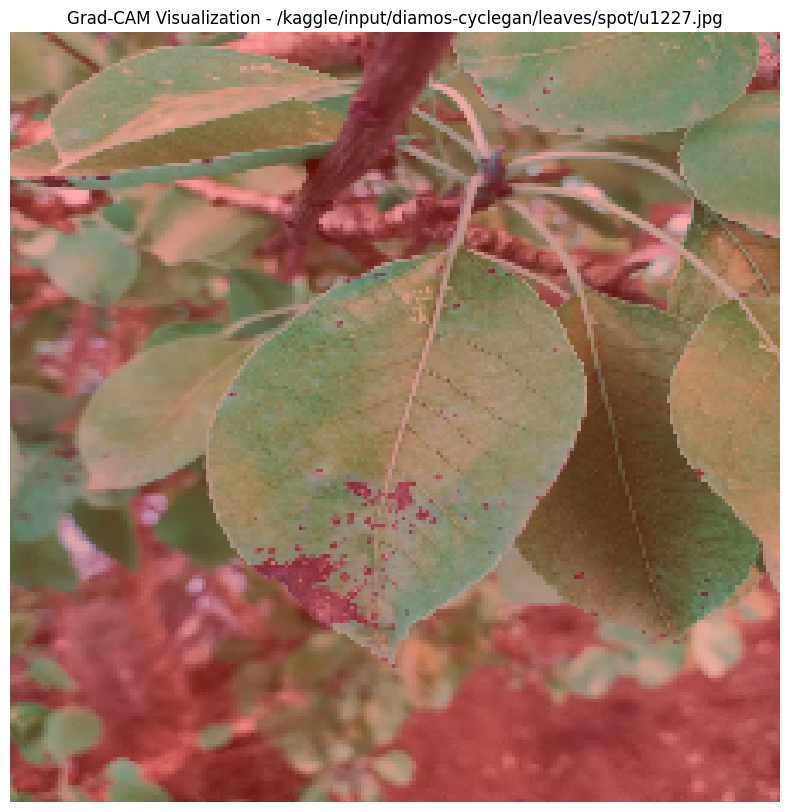

In [12]:
# Preprocess and visualize each image
for leaf_image_path in image_paths:
    leaf_image = Image.open(leaf_image_path)
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(leaf_image).unsqueeze(0).to(device)

    # Initialize Grad-CAM with the appropriate layer in the model
    target_layer = "conv4"  # Example: Use the final convolutional layer of the model
    grad_cam = GradCAM(trained_model, target_layer)

    # Generate CAM for the specified class (or the highest scoring class by default)
    cam = grad_cam.generate_cam(input_tensor)

    # Load the original image to overlay CAM
    image = cv2.imread(leaf_image_path)
    image = cv2.resize(image, (224, 224))
    image = np.float32(image) / 255

    # Overlay CAM on the image
    cam_image = show_cam_on_image(image, cam)

    # Display the Grad-CAM visualization
    plt.figure(figsize=(10, 10))
    plt.imshow(cam_image)
    plt.axis('off')
    plt.title(f"Grad-CAM Visualization - {leaf_image_path}")
    plt.show()